In [ ]:
!pip install transformers
!pip install datasets

In [2]:
import pandas as pd
import numpy as np
import torch

import gc

In [ ]:
!mkdir squad
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json -O squad/train-v2.0.json
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json -O squad/dev-v2.0.json

In [4]:
import json
from pathlib import Path

def read_squad(path):
    path = Path(path)
    with open(path, 'rb') as f:
        squad_dict = json.load(f)

    contexts = []
    questions = []
    answers = []
    for group in squad_dict['data']:
        for passage in group['paragraphs']:
            context = passage['context']
            for qa in passage['qas']:
                question = qa['question']
                for answer in qa['answers']:
                    contexts.append(context)
                    questions.append(question)
                    answers.append(answer)

    return contexts, questions, answers

train_contexts, train_questions, train_answers = read_squad('/content/squad/train-v2.0.json')
val_contexts, val_questions, val_answers = read_squad('/content/squad/dev-v2.0.json')

In [5]:
def add_end_idx(answers, contexts):
    for answer, context in zip(answers, contexts):
        gold_text = answer['text']
        start_idx = answer['answer_start']
        end_idx = start_idx + len(gold_text)

        if context[start_idx:end_idx] == gold_text:
            answer['answer_end'] = end_idx
        elif context[start_idx-1:end_idx-1] == gold_text:
            answer['answer_start'] = start_idx - 1
            answer['answer_end'] = end_idx - 1 
        elif context[start_idx-2:end_idx-2] == gold_text:
            answer['answer_start'] = start_idx - 2
            answer['answer_end'] = end_idx - 2 

add_end_idx(train_answers, train_contexts)
add_end_idx(val_answers, val_contexts)

In [ ]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

train_encodings = tokenizer(train_contexts, train_questions, truncation=True, padding=True)
gc.collect()
val_encodings = tokenizer(val_contexts, val_questions, truncation=True, padding=True)
gc.collect()

In [7]:
def add_token_positions(encodings, answers):
    start_positions = []
    end_positions = []
    for i in range(len(answers)):
        start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
        end_positions.append(encodings.char_to_token(i, answers[i]['answer_end'] - 1))

        if start_positions[-1] is None:
            start_positions[-1] = tokenizer.model_max_length
        if end_positions[-1] is None:
            end_positions[-1] = tokenizer.model_max_length

    encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

add_token_positions(train_encodings, train_answers)
add_token_positions(val_encodings, val_answers)

In [8]:
import torch

class SquadDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

train_dataset = SquadDataset(train_encodings)
val_dataset = SquadDataset(val_encodings)

In [ ]:
from transformers import DistilBertForQuestionAnswering
model = DistilBertForQuestionAnswering.from_pretrained("distilbert-base-uncased")

In [21]:
from torch.utils.data import DataLoader
from transformers import AdamW
from tqdm import trange

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model.to(device)
model.train()

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

optim = AdamW(model.parameters(), lr=5e-5)

epoch_loss = []
for epoch in range(3):
    for idx, batch in enumerate(train_loader):
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
        loss = outputs[0]
        loss.backward()
        optim.step()
        epoch_loss.append(loss.item())
        print("Batch: {0}    Epoch[{1}/3]    Training Loss: {2}".format(idx, epoch+1, epoch_loss[-1]))
    


model.eval()

Streaming output truncated to the last 5000 lines.
Batch: 427    Epoch[3/3]    Training Loss: 0.460075318813324
Batch: 428    Epoch[3/3]    Training Loss: 0.35041433572769165
Batch: 429    Epoch[3/3]    Training Loss: 0.40419939160346985
Batch: 430    Epoch[3/3]    Training Loss: 0.8635175228118896
Batch: 431    Epoch[3/3]    Training Loss: 0.36274808645248413
Batch: 432    Epoch[3/3]    Training Loss: 0.23200422525405884
Batch: 433    Epoch[3/3]    Training Loss: 0.45207974314689636
Batch: 434    Epoch[3/3]    Training Loss: 0.33109182119369507
Batch: 435    Epoch[3/3]    Training Loss: 0.15788090229034424
Batch: 436    Epoch[3/3]    Training Loss: 0.3248405158519745
Batch: 437    Epoch[3/3]    Training Loss: 0.31180256605148315
Batch: 438    Epoch[3/3]    Training Loss: 0.5565935373306274
Batch: 439    Epoch[3/3]    Training Loss: 0.7169691324234009
Batch: 440    Epoch[3/3]    Training Loss: 0.3736518621444702
Batch: 441    Epoch[3/3]    Training Loss: 0.3590708076953888
Batch: 442  

DistilBertForQuestionAnswering(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
import os
PATH = "/content/drive/MyDrive/Projects/Clubs/Analytics/Coord Projects/NLP/BERT"

In [24]:
torch.save({
            'epoch': 3,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optim.state_dict(),
            'loss': epoch_loss[-1]
            }, os.path.join(PATH, "bert.pth"))

In [28]:
import matplotlib.pyplot as plt

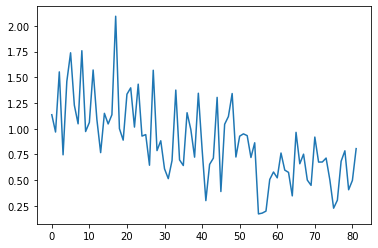

In [31]:
loss_plot = epoch_loss[::200]
plt.plot(np.arange(len(loss_plot)), loss_plot)

In [94]:
pred = []
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
for idx, batch in enumerate(val_loader):
    model.eval()
    with torch.no_grad():
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)

        pred_start_positions = torch.argmax(outputs['start_logits'])
        pred_end_positions = torch.argmax(outputs['end_logits'])+1

        pred.append({'Inputs': {'inputs': input_ids[0], 'start': start_positions[0], 'end': end_positions[0]+1},
                     'Outputs': {'start': pred_start_positions, 'end': pred_end_positions}})

In [96]:
outputs = []

for prediction in pred:
    input = prediction['Inputs']['inputs']
    
    start = prediction['Inputs']['start']
    end = prediction['Inputs']['end']
    pred_start = prediction['Outputs']['start']
    pred_end = prediction['Outputs']['end']

    sentence = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input[start:end]))
    pred_sentence = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input[pred_start:pred_end]))

    outputs.append({'Actual': sentence, 'Predicted': pred_sentence})

outputs = pd.DataFrame(outputs)

In [99]:
outputs.head(50)

,Actual,Predicted
0,france,france
1,france,france
2,france,france
3,france,france
4,10th and 11th centuries,10th and 11th centuries
5,in the 10th and 11th centuries,10th and 11th centuries
6,10th and 11th centuries,10th and 11th centuries
7,10th and 11th centuries,10th and 11th centuries
8,"denmark, iceland and norway","denmark, iceland and norway"
9,"denmark, iceland and norway","denmark, iceland and norway"
